# Signal Preprocessing Development

In [1]:
import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from typing import Callable, Literal, Tuple
import os

import mne
import mne_icalabel
import pywt

from scipy.signal import butter, filtfilt, iirnotch, welch, csd

from src.pipeline.visualizations import plot_eeg_heatmap, EEG_CHANNELS

import src.utils.file_management as filemgmt
from src.pipeline.preprocessing import BiosignalPreprocessor

In [2]:
ROOT = Path().resolve().parent
QTC_DATA = ROOT / "data" / "qtc_measurements" / "2025_06"
subject_data_dir = QTC_DATA / "sub-10"
SERIAL_DATA = ROOT / "data" / "serial_measurements"

mpl.use('macosx')

In [3]:
os.listdir(subject_data_dir)

['motor_eeg_full.npy', 'motor_emg2_full.npy', 'motor_emg1_full.npy']

## Preprocessor Class
Define class with filter functions applied automatically based on init booleans.

In [4]:
input_file = np.load(subject_data_dir / "motor_eeg_full.npy").T
data_modality: Literal['eeg', 'emg'] = 'eeg'
sampling_freq = 2048  # Hz

prepper = BiosignalPreprocessor(
    np_input_data=input_file,
    sampling_freq=sampling_freq,
    modality=data_modality,
    band_pass_frequencies='auto',
)

In [5]:
prepper.bad_channels

Creating RawArray with float64 data, n_channels=64, n_times=618369
    Range : 0 ... 618368 =      0.000 ...   301.938 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 67585 samples (33.000 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuatio

['F9', 'FT10', 'PO4']

In [6]:
prepper.np_artefact_free_data

Fitting ICA to data using 61 channels (please be patient, this may take a while)
Omitting 36105 of 618369 (5.84%) samples, retaining 582264 (94.16%) samples.
Selecting by number: 25 components
Computing Extended Infomax ICA
Fitting ICA took 43.5s.


/Users/paulrusing/Library/Mobile Documents/com~apple~CloudDocs/PR iCloud/Work/Personal/Programming/Github Repos/multimodal-biosignal-analysis/src/pipeline/preprocessing.py:598: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  self._ica_automatic_labels = mne_icalabel.label_components(self.mne_amplitude_compliant_data,


Found the following IC labels:
 ['other', 'other', 'channel noise', 'brain', 'brain', 'other', 'other', 'other', 'other', 'other', 'muscle artifact', 'brain', 'other', 'brain', 'brain', 'brain', 'other', 'brain', 'other', 'other', 'brain', 'other', 'other', 'other', 'other']
Will exclude ('heart beat', 'muscle artifact', 'channel noise') ICs, that are:  [2, 10]
Also excluding manual set ICs: []
(change this selection via manual_ics_to_exclude parameter)
Applying ICA to Raw instance
    Transforming to ICA space (25 components)
    Zeroing out 2 ICA components
    Projecting back using 61 PCA components
np data also contains bad channels (['F9', 'FT10', 'PO4']).
Consider excluding such manually!


array([[-8.80499812e-05, -9.07037029e-05, -9.11498829e-05, ...,
        -1.03515453e-04, -1.51510876e-03, -1.06763357e-04],
       [ 8.51699366e-04,  1.88137742e-03,  8.07578901e-04, ...,
        -2.90959515e-04,  8.65546941e-04,  1.97542525e-03],
       [ 1.72963730e-03,  3.74653281e-03,  1.67369163e-03, ...,
        -2.61373431e-04,  3.21037164e-03,  4.11096996e-03],
       ...,
       [ 2.31739371e-01,  2.34693807e-01,  2.33223742e-01, ...,
         2.27800791e-01, -4.17055800e-01,  2.23980371e-01],
       [ 1.17978384e-01,  1.19493298e-01,  1.18765048e-01, ...,
         1.15983602e-01, -2.13095162e-01,  1.14018425e-01],
       [-8.80499812e-05, -9.07037029e-05, -9.11498829e-05, ...,
        -1.03515453e-04, -1.51510876e-03, -1.06763357e-04]],
      shape=(618369, 64))

In [10]:
prepper._ica_automatic_labels

{'y_pred_proba': array([0.4251457 , 0.5306449 , 0.47514376, 0.6480664 , 0.52412945,
        0.6348131 , 0.768166  , 0.673771  , 0.6878788 , 0.86946344,
        0.89857554, 0.75378835, 0.53771305, 0.8795183 , 0.87775135,
        0.5107551 , 0.6214794 , 0.81589663, 0.4679028 , 0.6558374 ,
        0.24958797, 0.8424063 , 0.53237146, 0.92818856, 0.9923393 ],
       dtype=float32),
 'labels': ['other',
  'other',
  'channel noise',
  'brain',
  'brain',
  'other',
  'other',
  'other',
  'other',
  'other',
  'muscle artifact',
  'brain',
  'other',
  'brain',
  'brain',
  'brain',
  'other',
  'brain',
  'other',
  'other',
  'brain',
  'other',
  'other',
  'other',
  'other']}

In [1]:
prepper.manual_ics_to_exclude = [8, 9]

NameError: name 'prepper' is not defined

In [1]:
prepper.plot_independent_component(1)

NameError: name 'prepper' is not defined

In [8]:
prepper.discrete_fourier_transform(prepper.np_input_data)

NameError: name 'sampling_freq' is not defined

In [ ]:
prepper.discrete_fourier_transform(prepper.np_output_data)

## Preprocesing Pipeline:
1. Bandpass Filter
2. Notch (with harmonics)
3. Re-referencing
4. Rectification? (if, only EMG)
5. Artefact Removal (ICA / BSS)
6. Smoothing (Laplacian spatial filter)
7. Wavelet Denoising

### Bandpass Filter

In [32]:
def get_bandpass_filter_coefficients(lowcut_freq: float = 3.0,
                                 highcut_freq: float = 80.0,
                                 sampling_freq: int = 2048,
                                 order: int = 2,  # slope steepness
                                 ) -> Tuple[Tuple[float], Tuple[float]]:
    """
    Design Butterworth bandpass filter coefficients for EEG signal filtering.

    Parameters
    ----------
    lowcut_freq : float, optional
        Lower cutoff frequency of the bandpass filter in Hz, default is 3.0.
    highcut_freq : float, optional
        Upper cutoff frequency of the bandpass filter in Hz, default is 80.0.
    sampling_freq : int, optional
        Sampling frequency of the signal in Hz, default is 2048.
    order : int, optional
        Order of the Butterworth filter which controls the slope steepness, default is 2.

    Returns
    -------
    b : tuple of float
        Numerator coefficients of the IIR filter transfer function.
    a : tuple of float
        Denominator coefficients of the IIR filter transfer function.
    """
    nyquist_freq = 0.5 * sampling_freq  # nyquist freq (max. depictable signal) is half sampling rate
    low = lowcut_freq / nyquist_freq  # normalise cut-offs
    high = highcut_freq / nyquist_freq
    b, a = butter(order, [low, high], btype='band')  # use scipy butterworth filter
    return b, a  # arrays of coefficients for filter transfer functions (b = numerator, a = denominator)

def apply_band_pass_filter(signal: np.ndarray,
                           b: Tuple[float] = None,
                           a: Tuple[float] = None,
                           axis: Literal[0, 1] | None = None,  # axis to filter on (0=filter columns, 1=filter rows)
                           **filter_kwargs) -> np.ndarray:
    """
    Apply zero-phase Butterworth bandpass filter to a signal.

    Parameters
    ----------
    signal : np.ndarray
        Input signal array, can be 1D or 2D.
    b : tuple of float, optional
        Numerator coefficients of the filter. If None, filter coefficients are generated using filter_kwargs.
    a : tuple of float, optional
        Denominator coefficients of the filter. If None, filter coefficients are generated using filter_kwargs.
    axis : {0, 1} or None, optional
        Axis along which to apply the filter for 2D inputs.
        0 means filter columns, 1 means filter rows.
        Must be specified if signal is 2D.
    **filter_kwargs : dict, optional
        Additional keyword arguments passed to `get_bandpass_filter_coefficients`
        if b and a are not provided.

    Returns
    -------
    np.ndarray
        Filtered signal with the same shape as input.

    Raises
    ------
    ValueError
        If signal is 2D and axis is not specified.
    """
    if b is None or a is None: b, a = get_bandpass_filter_coefficients(**filter_kwargs)
    if len(signal.shape) > 1 and axis is None: raise ValueError("For 2D signal arrays, axis needs to be defined!")
    return filtfilt(b, a, signal, axis=axis)

In [105]:
freq_range = (.1, 100) if data_modality == "eeg" else (20, 500)

In [106]:
bpfiltered_data_array = apply_band_pass_filter(data_array, axis=0,
                                               # kwargs:
                                               lowcut_freq=3.0, highcut_freq=80, sampling_freq=sampling_freq)  # 2s

### Notch Filter

In [107]:
def apply_notch_filter(signal: np.ndarray, sampling_freq: float, notch_freq: float,
                 harmonics: int = 1, Q: float = 30,
                 axis: Literal[0, 1] | None = None,  # axis to filter on (0=filter columns, 1=filter rows)
                 ):
    """
    Apply notch filters to remove the fundamental frequency and its harmonics from a signal.

    Parameters
    ----------
    signal : array_like
        Input signal array to be filtered.
    sampling_freq : int or float
        Sampling frequency of the signal in Hz.
    notch_freq : float
        Fundamental frequency to be removed (Hz).
    harmonics : int, optional
        Number of harmonics to remove including the fundamental. Default is 1.
    Q : float, optional
        Quality factor, controls the bandwidth of the notch filter. Higher values correspond to narrower notch. Default is 30.

    Returns
    -------
    numpy.ndarray
        Filtered signal with the specified frequencies removed.
    """
    if len(signal.shape) > 1 and axis is None: raise ValueError("For 2D signal arrays, axis needs to be defined!")
    filtered_signal = signal.copy()
    for i in range(1, harmonics + 1):
        target_freq = notch_freq * i
        w0 = target_freq / (sampling_freq / 2)  # Normalized frequency
        b, a = iirnotch(w0, Q)
        filtered_signal = filtfilt(b, a, filtered_signal, axis=axis)
    return filtered_signal

In [108]:
notchfiltered_data_array = apply_notch_filter(bpfiltered_data_array, sampling_freq=sampling_freq,
                                              notch_freq=50, harmonics=3 if data_modality == "eeg" else 10,
                                              axis=0)  # 2.5s per harmonic

### Re-Referencing

In [109]:
def rereference_signal(signal: np.ndarray,
                       reference_channel: str | int | None = None,
                       axis: Literal[0, 1] | None = None,
                       ) -> np.ndarray:
    """
    Re-reference a signal based on a specified reference channel or whole-brain average.

    Parameters
    ----------
    signal : np.ndarray
        Input signal array. Can be 1D or 2D.
    reference_channel : str or int or None, optional
        Reference channel to re-reference the signal.
        If str, the index is derived based on the 10-20 EEG structure.
        If None (default), re-referencing is done to the whole-brain average.
    axis : {0, 1} or None, optional
        Axis along which to apply re-referencing for 2D signals.
        axis=0 means channels are in columns,
        axis=1 means channels are in rows.
        Must be defined if `signal` is 2D.

    Returns
    -------
    np.ndarray
        Re-referenced signal array with the same shape as input.

    Raises
    ------
    ValueError
        If signal is 2D and axis is not specified.
    """
    if len(signal.shape) > 1 and axis is None: raise ValueError("For 2D signal arrays, axis needs to be defined!")
    if reference_channel is not None:
        if isinstance(reference_channel, str):  # derive ind if necessary:
            reference_channel = EEG_CHANNELS.index(reference_channel)

        if axis == 0: return signal - signal[:, reference_channel][:, np.newaxis]
        else: return signal - signal[reference_channel, :][np.newaxis, :]

    else:  # use whole-brain average
        return signal - np.mean(signal, axis=axis)

In [114]:
referenced_signal = rereference_signal(notchfiltered_data_array, axis=0)

In [115]:
referenced_signal

array([[ 0.0194973 ,  0.02243476,  0.02363216, ...,  0.02228757,
         0.08274446,  0.02627624],
       [ 0.01926038,  0.02294597,  0.02365056, ...,  0.02284654,
         0.09220521,  0.02785088],
       [ 0.01921932,  0.02360366,  0.02384711, ...,  0.02357915,
         0.10187441,  0.0295202 ],
       ...,
       [-0.06406475, -0.05572395, -0.06426027, ..., -0.07985561,
        -1.92221513, -0.08834114],
       [-0.05612045, -0.04867057, -0.05654274, ..., -0.07075016,
        -1.71688169, -0.07819645],
       [-0.0478428 , -0.04130736, -0.04853987, ..., -0.06129843,
        -1.49988215, -0.06762433]], shape=(618369, 64))

### Rectification

In [116]:
def full_wave_rectify(signal: np.ndarray, verbose: bool = True) -> np.ndarray:
    """
    Perform full-wave rectification on the input signal.

    Parameters
    ----------
    signal : np.ndarray
        Input signal array to be rectified.

    Returns
    -------
    np.ndarray
        Full-wave rectified signal.
    """
    if verbose: print("Rectified data.")
    return np.abs(signal)

In [117]:
if data_modality == 'emg': referenced_signal = full_wave_rectify(referenced_signal)

### Artefact Removal
Blind source separation / Independent Component Analysis

MNE library for medical-related artefact removal in measurements: https://www.frontiersin.org/journals/neuroscience/articles/10.3389/fnins.2013.00267/full?gad_source=1&gad_campaignid=23187344532&gbraid=0AAAAAC_sJ7ksdJqOBO-TfepsWwOjpXu61&gclid=EAIaIQobChMI57GoqrTnkAMVg5KDBx2_ewCGEAAYASAAEgIp0vD_BwE
1. amplitude thresholding
2. ICA
3. Eventually artifact regression leveraging other channels?

MNE-ICALabel for automatic ICA labelling: https://mne.tools/mne-icalabel/stable/index.html

        The first few versions of mne-icalabel replicated the popular ICLabel model for Python
        (previously only available in MATLAB’s EEGLab). In future versions, the package aims
        to develop more robust models that build upon the ICLabel model.

#### Import to MNE

In [119]:
data_info = mne.create_info(ch_names=EEG_CHANNELS, sfreq=sampling_freq,
                            ch_types=data_modality)
mne_data = mne.io.RawArray(referenced_signal.T, data_info)
mne_data.set_montage(mne.channels.make_standard_montage('standard_1020'))

# filtering (done before)
#   mne_data.filter(l_freq=3.0, h_freq=80.0, fir_design='firwin')
#   mne_data = mne_data.copy().notch_filter(freqs=[50, 100, 150], picks='all')

# rereferencing (done before)
#   mne_data.set_eeg_reference(ref_channels='average')

Creating RawArray with float64 data, n_channels=64, n_times=618369
    Range : 0 ... 618368 =      0.000 ...   301.938 secs
Ready.


<RawArray | 64 x 618369 (301.9 s), ~302.0 MiB, data loaded>

#### Amplitude-based Rejection
Commonly, amplitudes beyond roughly 100-150 µV are considered too large for typical EEG signals.

In [120]:
# define rejection thresholds
reject_criteria = dict(eeg=.001)  # now 1000 µV peak-to-peak threshold for EEG channels

# derive annotations:
annotations, bad_channels = mne.preprocessing.annotate_amplitude(
    mne_data,
    peak=reject_criteria,
    min_duration=.025,  # minimum duration for consecutive samples to exceed or fall below threshold
    bad_percent=5,  # channels with more bad segments will be marked as complete bad channels
)
print(f"Found {len(bad_channels)} bad channels.")
mne_data.set_annotations(annotations)
mne_data.info['bads'].extend(bad_channels)

Finding segments below or above PTP threshold.
Found 2 bad channels.


In [121]:
# visualize:
mne_data.plot(scalings=dict(eeg=.01),  # y-scaling
              n_channels=8, duration=3,  # channels and seconds per page
              )

<MNEBrowseFigure size 2876x1600 with 4 Axes>

In [122]:
mne_data.info

<Info | 9 non-empty values
 bads: 2 items (FT10, PO4)
 ch_names: Fpz, Fp1, Fp2, AF7, AF3, AF4, AF8, F9, F7, F5, F3, F1, Fz, F2, ...
 chs: 64 EEG
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG)
 highpass: 0.0 Hz
 lowpass: 1024.0 Hz
 meas_date: unspecified
 nchan: 64
 projs: []
 sfreq: 2048.0 Hz
>

#### ICA + Automatic Labelling

In [103]:
# fit ICA:
ica = mne.preprocessing.ICA(n_components=25, max_iter='auto',
                            method='infomax',  # switches between nonlinearities, appears more robust but takes much longer (than FastICA)
                            fit_params=dict(extended=True))
# convergence is difficult with too short datasets, rule of thumb appears to be n-components x 20-30 = required_seconds
ica.fit(mne_data)

Fitting ICA to data using 62 channels (please be patient, this may take a while)
Omitting 37585 of 618369 (6.08%) samples, retaining 580784 (93.92%) samples.


/var/folders/x7/nz50lkr91vv70_d8w82gt35c0000gn/T/ipykernel_4159/2410931727.py:4: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(mne_data)


Selecting by number: 25 components
Computing Extended Infomax ICA
Fitting ICA took 50.0s.


Method,infomax
Fit parameters,extended=Truemax_iter=500
Fit,500 iterations on raw data (580784 samples)
ICA components,25
Available PCA components,62
Channel types,eeg
ICA components marked for exclusion,—


In [104]:
# label ica components:
ica_label_output = mne_icalabel.label_components(mne_data, ica, method='iclabel')
probs, labels = ica_label_output.values()
print("Found the following labels:\n", labels)

# exclude such
ica.exclude = [idx for idx, label in enumerate(labels) if label in ('heart beat', 'muscle artifact')]
ica.exclude

/var/folders/x7/nz50lkr91vv70_d8w82gt35c0000gn/T/ipykernel_4159/3286218303.py:2: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ica_label_output = mne_icalabel.label_components(mne_data, ica, method='iclabel')


In [128]:
# todo: better understand and utilise this plot:
# ica.plot_properties(mne_data, picks=16)

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
68 matching events found
No baseline correction applied
0 projection items activated


KeyboardInterrupt: 

#### Exclude Artefact-ICs and Re-Convert

In [136]:
# Apply ICA with excluded components
artefact_free_data = ica.apply(mne_data.copy()).get_data().T  # backproject ICs to sensor space while omitting ica.exclude list
# afterwards get_data() yields numpy and T re-shapes again to (n_channels, n_timesteps)

# save bad channels:
channels_to_omit = mne_data.info['bads']

Applying ICA to Raw instance
    Transforming to ICA space (25 components)
    Zeroing out 2 ICA components
    Projecting back using 62 PCA components


### Smoothing
Laplacian Spatial Filter acts as a **spatial high-pass filter**, i.e. removes common input from neighboring electrodes to emphasize local signal differences.

In [143]:
# 3d coords of channels (from MNE)
_ = mne_data.get_montage()  # checks whether montage was provided
pos = np.array([mne_data.info['chs'][i]['loc'][:3] for i in range(len(mne_data.ch_names))])  # 3D coords of channels

In [153]:
def apply_laplacian_spatial_filter(input_data: np.ndarray,
                                   positional_mapping: np.ndarray,
                                   neighbor_radius: float = .05) -> np.ndarray:
    # sanity checks:
    if positional_mapping.shape[1] != 3: raise ValueError("Positional mapping needs to provide 3D coordinates for each channel (shape: n_channels x 3)")
    if positional_mapping.shape[0] != input_data.shape[1]: raise ValueError("Input data needs to have channels as columns (shape: n_timesteps x n_channels)")

    def find_neighbors(positions, radius=0.05):
        """ Identify proximal EEG channels based on positional mapping. """
        output_mapping = []
        for i, pos_i in enumerate(positions):
            dists = np.linalg.norm(positions - pos_i, axis=1)  # compute Euclidean dist from current electrode to all others
            # find neighbors by: excluding self and keeping channels within radius
            neigh = np.where((dists > 0) & (dists < radius))[0]
            output_mapping.append(neigh)
        return output_mapping

    # compute neighbor mapping:
    neighbors = find_neighbors(positional_mapping, neighbor_radius)

    # Compute Laplacian-filtered data
    laplacian_data = np.zeros_like(input_data)  # prepare output array
    for i, neigh_idx in enumerate(neighbors):  # iterate over channels
        if len(neigh_idx) > 0:  # subtract neighbors' average:
            laplacian_data[:, i] = input_data[:, i] - input_data[:, neigh_idx].mean(axis=1)
        else:  # no neighbors: keep original:
            laplacian_data[:, i] = input_data[:, i]

    return laplacian_data

In [156]:
spatially_filtered_data = apply_laplacian_spatial_filter(artefact_free_data, pos)

### Denoising (Wavelet)
Discrete Wavelet Transform (DWT) decomposes a signal into approximation (low freqs.) and detail (high freqs.) coefficients. Noise is commonly contained into detail coefficients, hence these are cut-off.

In [157]:
input_data = spatially_filtered_data.copy()

In [172]:
type(wavelet_coeffs[0])

numpy.ndarray

In [217]:
def compute_wavelet_coefficients(input_data: np.ndarray,
                                 wavelet_type: Literal['db4', 'sym5', 'coif1'] = 'db4',
                                 ) -> list[np.ndarray[np.ndarray[float]]]:
    # define wavelet and decomposition level:
    max_level = pywt.dwt_max_level(len(input_data),
                                   pywt.Wavelet(wavelet_type).dec_len)  # up to which level to decompose

    # compute wavelet coefficients:
    return pywt.wavedec(input_data, wavelet_type, level=max_level)

In [219]:
def denoise_wavelet_coefficients(coefficients: list[np.ndarray[np.ndarray[float]]],
                                 n_coeffs_to_skip: int = 1,  # leave first (approximation) coefficient unaltered
                                 threshold_mode: Literal['soft', 'hard'] = 'soft',
                                 ) -> list[np.ndarray[np.ndarray[float]]]:
    # select finest scale coefficient (highest frequency noise) to estimate noise level:
    detail_coeffs = coefficients[-1]

    # compute noise threshold:
    sigma = np.median(np.abs(detail_coeffs)) / .6745  # factor .6745 converts median absolute deviation to standard deviation assuming Gaussian noise
    uthresh = sigma * np.sqrt(2 * np.log(len(detail_coeffs)))  # universal threshold (Donoho's), common for balancing signal preservation and noise reduction
    # other (adaptive) options: SURE, Minimax, BayesShrink

    # denoise coefficients:
    denoised_coeffs = [np.array(*coefficients[:n_coeffs_to_skip])]  # initialise denoised list by keeping approximation coeffs (index 0) unaltered
    for coeff in coefficients[n_coeffs_to_skip:]:
        denoised_coeff = pywt.threshold(coeff, value=uthresh, mode=threshold_mode)  # apply soft thresholding to shrink coefficients below threshold
        denoised_coeffs.append(denoised_coeff)

    return denoised_coeffs

In [221]:
def reconstruct_signal_from_wavelets(coefficients: list[np.ndarray[np.ndarray[float]]],
                                     wavelet_type: Literal['db4', 'sym5', 'coif1'] = 'db4',) -> np.ndarray:
    return pywt.waverec(coefficients, wavelet_type)

In [222]:
coeffs = compute_wavelet_coefficients(spatially_filtered_data,
                                      'db4')
denoised_coeffs = denoise_wavelet_coefficients(coeffs)

In [223]:
denoised_data = reconstruct_signal_from_wavelets(denoised_coeffs, 'db4')

In [224]:
denoised_data

array([[ 7.32783512e-03,  2.05054002e-02,  1.30309662e-02, ...,
        -1.35294104e-01, -1.29313907e-01, -3.58521977e-01],
       [ 7.25241258e-03,  2.09538316e-02,  1.30443497e-02, ...,
        -1.47184968e-01, -1.29622400e-01, -3.85066087e-01],
       [ 7.39396447e-03,  2.16349215e-02,  1.33232885e-02, ...,
        -1.59082689e-01, -1.30269258e-01, -4.12491273e-01],
       ...,
       [-2.54692635e-03, -2.71547640e-02, -2.19754614e-02, ...,
         1.38729117e+00,  1.41450520e+00,  7.28726104e+00],
       [-4.52830059e-03, -2.78548522e-02, -2.22744916e-02, ...,
         1.24903544e+00,  1.25988320e+00,  6.49985754e+00],
       [-6.50585003e-03, -2.84720525e-02, -2.25083102e-02, ...,
         1.10126877e+00,  1.09658218e+00,  5.66678916e+00]],
      shape=(618369, 64))

## Frequency Domain Representation

### Fourier Transform

In [95]:
def discrete_fourier_transform(input_array: np.ndarray, axis: Literal[0, 1] | None = None, plot_result: bool = True, **plot_kwargs) -> tuple[np.ndarray, np.ndarray]:
    """ To be commented. """
    # input sanity checks:
    if len(input_array.shape) == 1:
        input_array = input_array[:, np.newaxis]
        if axis is None: axis = 0
    else:
        if axis is None: raise AttributeError("For 2D signal arrays, axis needs to be defined!")

    # descriptive parameters:
    n_samples = input_array.shape[axis]

    # compute discrete FT with FFT algorithm:
    fft_result = np.fft.fft(input_array, axis=axis)  # shape is as input
    freqs_fft = np.fft.fftfreq(n_samples, d=1/sampling_freq)    # frequency bin labels [Hz]

    # retain only positive frequencies (FFT of real-valued signals is symmetric)
    freqs_pos = freqs_fft[freqs_fft >= 0]
    fft_pos = fft_result[freqs_fft >= 0, :] if axis == 0 else fft_result[:, freqs_fft >= 0]

    # compute magnitude:
    amplitude_spectrum = np.abs(fft_pos) * 2 / n_samples  # normalize amplitude by 2/n_samples

    # eventually plot:
    if plot_result: plot_freq_domain(amplitude_spectrum, freqs_pos, **plot_kwargs)

    return amplitude_spectrum, freqs_pos

# todo: include typical frequency annotations
def plot_freq_domain(amplitude_spectrum: np.ndarray[float, float] | np.ndarray[float],
                     frequencies: np.ndarray[float],
                     frequency_range: tuple[float, float] = None,
                     channel_labels: np.ndarray[str] = None,
                     plot_size: tuple[float, float] = (12, 6),
                     plot_title: str = "Magnitude Spectrum"):
    """"""
    # initialise figure:
    plt.figure(figsize=plot_size)

    # plot lines per channel:
    if len(amplitude_spectrum.shape) == 1:  # extend by pseudo-axis if only 1D array provided
        amplitude_spectrum = amplitude_spectrum[:, np.newaxis]
    for ch in range(amplitude_spectrum.shape[1]):
        plt.plot(frequencies, amplitude_spectrum[:, ch], label=f'Channel {ch+1}' if channel_labels is None else channel_labels[ch])
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Amplitude')
    plt.title(plot_title)
    plt.legend(ncols=amplitude_spectrum.shape[1] // 16 + 1)
    plt.xlim(frequency_range)
    plt.show()

#### Unfiltered Data

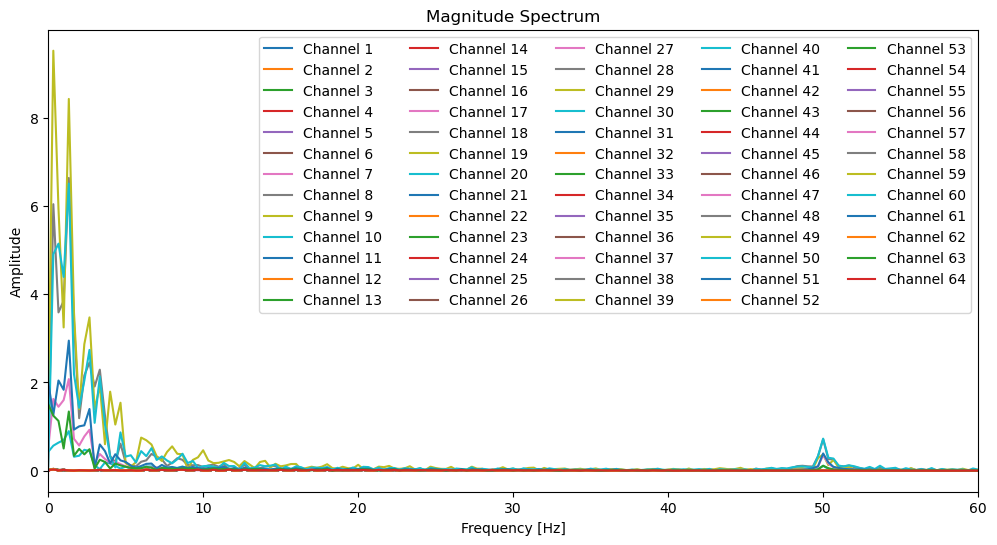

In [112]:
_, _ = discrete_fourier_transform(input_array=data_array[:,:], axis=0, plot_result=True, frequency_range=(0, 60))

#### Filtered Data

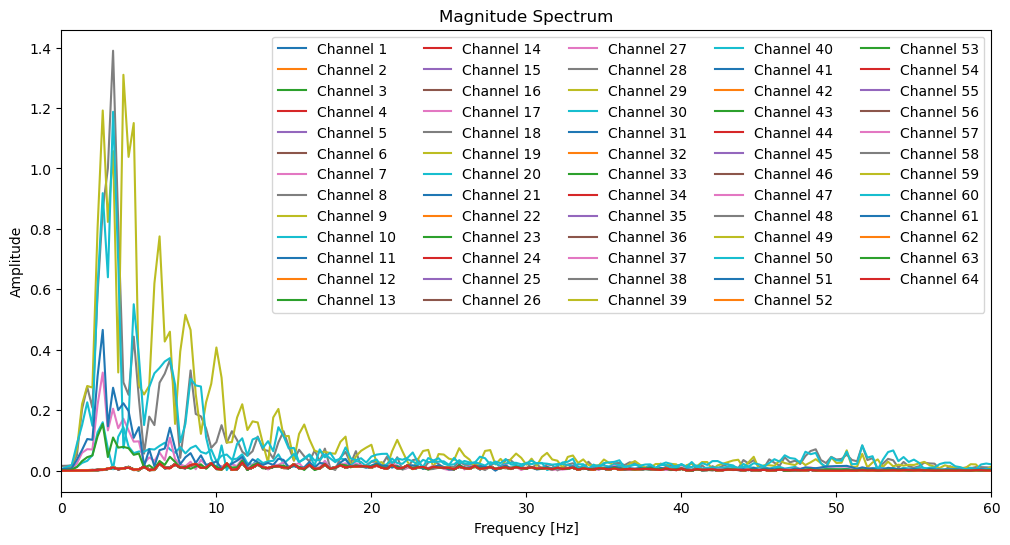

In [113]:
_, _ = discrete_fourier_transform(input_array=notchfiltered_data_array[:, :],
                           axis=0, plot_result=True, frequency_range=(0, 60))